In [2]:
import numpy as np
import random as rand
import pandas as pd
import matplotlib.pyplot as plt
import gensim  
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.utils import plot_model, pad_sequences
# from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tqdm import tqdm
from nltk.corpus import stopwords
# from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs
import nltk
np.random.seed(0)

nltk.download('stopwords')
MAX_NB_WORDS = 100000
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
embeddings_index = {}
f = codecs.open('./drive/MyDrive/MLProject/wiki-news-300d-1M.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

999995it [02:25, 6868.61it/s]

found 999995 word vectors


In [5]:
word_vectors = gensim.models.KeyedVectors.load_word2vec_format('./drive/MyDrive/MLProject/GoogleNews-vectors-negative300.bin', binary=True)

In [6]:
def splitIntoStem(message):
    return [removeNumeric(stripEmoji(singleCharacterRemove(removePunctuation
                                                           (removeHyperlinks
                                                            (removeHashtags
                                                             (removeUsernames
                                                              (stemWord(word)))))))) for word in message.split()]
def stemWord(tweet):
    return tweet.lower()

def removeUsernames(tweet):
    return re.sub('@[^\s]+', '', tweet)

def removeHashtags(tweet):
    return re.sub(r'#[^\s]+', '', tweet)

def removeHyperlinks(tweet):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', tweet)

def removeNumeric(value):
    blist2 = [item for item in value if not item.isdigit()]
    blist3 = "".join(blist2)
    return blist3

def removePunctuation(tweet):

    return re.sub(r'[^\w\s]','',tweet)

def singleCharacterRemove(tweet):
    return re.sub(r'(?:^| )\w(?:$| )', ' ', tweet)

def stripEmoji(text):

    RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
    return RE_EMOJI.sub(r'', text)

In [8]:
#load data
tweets_df = pd.read_csv('./tweets_dataset1.csv', sep=',', header=0)
tweet_list = tweets_df['tweet'].tolist()
label_names = ["business", "entertainment", "health", "politics"]
labels = tweets_df[label_names].values

In [9]:
processed_list = []
for sentence in tqdm(tweet_list):
    tokens = " ".join(splitIntoStem(sentence)).split()
    filtered = [word for word in tokens if word not in stop_words]
    processed_list.append(" ".join(filtered))

100%|██████████| 21149/21149 [00:05<00:00, 4083.55it/s]


In [10]:
df = pd.DataFrame()
df["tweet"] = processed_list
df['doc_len'] = df['tweet'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(df['doc_len'].mean() + df['doc_len'].std()).astype(int)
max_seq_len

11

In [11]:
x_train, x_test, y_train, y_test = train_test_split(processed_list, labels, test_size=0.2)

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train + x_test)
word_seq_train = tokenizer.texts_to_sequences(x_train)
word_seq_test = tokenizer.texts_to_sequences(x_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

dictionary size:  20091


In [13]:
num_tokens = [len(tokens) for tokens in word_seq_train + word_seq_test]
num_tokens = np.array(num_tokens)
num_tokens

array([ 9,  6,  5, ...,  3,  5, 11])

In [15]:
#pad sequences
word_seq_train = pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = pad_sequences(word_seq_test, maxlen=max_seq_len)

In [16]:
word_seq_test = word_seq_test[:-1]
y_test = y_test[:-1]

In [17]:
#training params
batch_size = 2048
epochs = 12

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

In [18]:
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
embedding_matrix2 = np.zeros((nb_words, embed_dim))

In [19]:
words_not_found = []

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
print("sample words not found: ", np.random.choice(words_not_found, 10))

number of null word embeddings: 4069
sample words not found:  ['eyesâ' 'shopify' 'indepndnt' 'doinâ' 'sisson' 'littlewe' 'strai'
 'washingtonarea' 'allentown' 'katies']


In [20]:
for word, i in word_index.items():
    if i >= nb_words:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix2[i] = embedding_vector
    except KeyError:
        embedding_matrix2[i]=np.random.normal(0,np.sqrt(0.25),embed_dim)

del(word_vectors)

In [21]:
model = Sequential()
model.add(Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
model.add(Conv1D(64, 7, padding='same', activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(64, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(GlobalMaxPooling1D())
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='softmax'))
opt = keras.optimizers.Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 11, 300)           6027300   
                                                                 
 conv1d (Conv1D)             (None, 11, 64)            134464    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 5, 64)             28736     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 2, 64)            0         
 1D)                                                             
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 6,192,712
Trainable params: 165,412
Non-trainable params: 6,027,300
_________________________________________________________________


In [23]:
history = model.fit(word_seq_train, y_train, batch_size = batch_size, epochs = epochs, shuffle = True, validation_data = (word_seq_test, y_test))

Epoch 1/12
9/9 [==============================] - 12s 1s/step - loss: 1.2513 - accuracy: 0.4126 - val_loss: 1.0151 - val_accuracy: 0.5630
Epoch 2/12
9/9 [==============================] - 6s 647ms/step - loss: 0.9487 - accuracy: 0.6081 - val_loss: 0.8601 - val_accuracy: 0.6581
Epoch 3/12
9/9 [==============================] - 6s 649ms/step - loss: 0.8145 - accuracy: 0.6730 - val_loss: 0.7937 - val_accuracy: 0.6874
Epoch 4/12
9/9 [==============================] - 4s 443ms/step - loss: 0.7039 - accuracy: 0.7252 - val_loss: 0.7725 - val_accuracy: 0.6964
Epoch 5/12
9/9 [==============================] - 4s 425ms/step - loss: 0.5823 - accuracy: 0.7724 - val_loss: 0.7684 - val_accuracy: 0.7113
Epoch 6/12
9/9 [==============================] - 4s 485ms/step - loss: 0.4537 - accuracy: 0.8290 - val_loss: 0.8415 - val_accuracy: 0.7148
Epoch 7/12
9/9 [==============================] - 5s 562ms/step - loss: 0.3329 - accuracy: 0.8736 - val_loss: 0.8590 - val_accuracy: 0.7245
Epoch 8/12
9/9 [======

In [24]:
model2 = Sequential()
model2.add(Embedding(nb_words, embed_dim, weights=[embedding_matrix2], input_length=max_seq_len, trainable=False))
model2.add(Conv1D(64, 7, padding='same', activation='relu'))
model2.add(MaxPooling1D(2))
model2.add(Conv1D(64, 7, activation='relu', padding='same'))
model2.add(MaxPooling1D(2))
model2.add(GlobalMaxPooling1D())
model2.add(Dropout(0.5))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(4, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 11, 300)           6027300   
                                                                 
 conv1d_4 (Conv1D)           (None, 11, 64)            134464    
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 5, 64)            0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 5, 64)             28736     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 2, 64)            0         
 1D)                                                             
                                                                 
 global_max_pooling1d_2 (Glo  (None, 64)              

In [25]:
history2 = model2.fit(word_seq_train, y_train, batch_size = batch_size, epochs = epochs, shuffle = True, validation_data = (word_seq_test, y_test))

Epoch 1/12
9/9 [==============================] - 7s 631ms/step - loss: 1.3674 - accuracy: 0.3268 - val_loss: 1.2856 - val_accuracy: 0.4963
Epoch 2/12
9/9 [==============================] - 4s 434ms/step - loss: 1.2296 - accuracy: 0.4647 - val_loss: 1.0887 - val_accuracy: 0.5628
Epoch 3/12
9/9 [==============================] - 4s 423ms/step - loss: 1.0723 - accuracy: 0.5482 - val_loss: 0.9732 - val_accuracy: 0.5973
Epoch 4/12
9/9 [==============================] - 5s 526ms/step - loss: 0.9722 - accuracy: 0.5997 - val_loss: 0.9201 - val_accuracy: 0.6328
Epoch 5/12
9/9 [==============================] - 5s 537ms/step - loss: 0.9089 - accuracy: 0.6374 - val_loss: 0.8812 - val_accuracy: 0.6486
Epoch 6/12
9/9 [==============================] - 4s 415ms/step - loss: 0.8538 - accuracy: 0.6661 - val_loss: 0.8511 - val_accuracy: 0.6642
Epoch 7/12
9/9 [==============================] - 4s 409ms/step - loss: 0.8064 - accuracy: 0.6859 - val_loss: 0.8305 - val_accuracy: 0.6716
Epoch 8/12
9/9 [====

In [26]:
y_pred = model.predict(word_seq_test)
y_pred_bool = np.argmax(y_pred, axis=1)
rounded_labels = np.argmax(y_test, axis = 1)
print(classification_report(rounded_labels, y_pred_bool))

133/133 [==============================] - 2s 12ms/step
              precision    recall  f1-score   support

           0       0.72      0.65      0.69      1051
           1       0.65      0.76      0.70      1099
           2       0.75      0.75      0.75      1078
           3       0.79      0.73      0.76      1001

    accuracy                           0.72      4229
   macro avg       0.73      0.72      0.73      4229
weighted avg       0.73      0.72      0.72      4229



In [27]:
y_pred = model2.predict(word_seq_test)
y_pred_bool = np.argmax(y_pred, axis=1)
rounded_labels = np.argmax(y_test, axis = 1)
print(classification_report(rounded_labels, y_pred_bool))

133/133 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.65      0.65      0.65      1051
           1       0.64      0.76      0.69      1099
           2       0.79      0.70      0.74      1078
           3       0.78      0.71      0.74      1001

    accuracy                           0.71      4229
   macro avg       0.71      0.71      0.71      4229
weighted avg       0.71      0.71      0.71      4229



In [29]:
loss1 = history.history['loss']
val_loss1 = history.history['val_loss']
acc1 = history.history['accuracy']
val_acc1 = history.history['val_accuracy']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']

epochs1 = range(1, len(loss1) + 1)

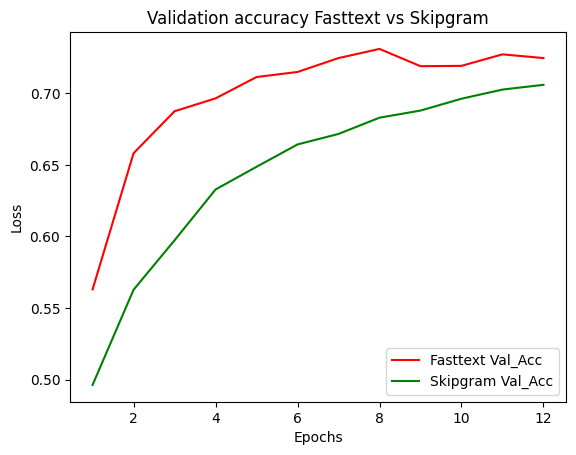

In [30]:
plt.plot(epochs1, val_acc1, color='red', label='Fasttext Val_Acc')
plt.plot(epochs1, val_acc2, color='green', label='Skipgram Val_Acc')
plt.title('Validation accuracy Fasttext vs Skipgram')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [31]:
#Binary to Real Mapping
Num_filters = [32, 64, 128, 256]
Batch = [64, 256, 1024, 2048]
Filter_size = [5, 7, 9, 11]

# x -> np array BPSO Particle
x = np.random.randint(2, size = 6)
print(x)

nf = int("".join(map(str, x[0:2])), 2)
bp = int("".join(map(str, x[2:4])), 2)
fs = int("".join(map(str, x[4:6])), 2)

num_filters = Num_filters[nf]
bp = Batch[bp]
filter_size = Filter_size[fs]

[1 1 1 1 0 1]


In [32]:
def cnn_optimizer(x):
    nf = int("".join(map(str, x[0:2])), 2)
    bp = int("".join(map(str, x[2:4])), 2)
    fs = int("".join(map(str, x[4:6])), 2)
    num_filters = Num_filters[nf]
    batch = Batch[bp]
    filter_size = Filter_size[fs]
#     return model(num_filters, batch, filter_size, word_seq_train, y_train, word_seq_test, y_test)
    model = model_build(num_filters, batch, filter_size, word_seq_train, y_train, word_seq_test, y_test)
    history = model.fit(word_seq_train, y_train, batch_size = batch, epochs = epochs, shuffle = True, validation_data = (word_seq_test, y_test))
    score, acc = model.evaluate(word_seq_test, y_test)
    print('Val accuracy:', acc)
    return acc

In [33]:
def model(num_filters, batch, filter_size, word_seq_train, y_train, word_seq_test, y_val):
    model = Sequential()
    model.add(Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
    model.add(Conv1D(num_filters, filter_size, padding='same', activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    history = model.fit(word_seq_train, y_train, batch_size = batch, epochs = epochs, shuffle = True, validation_data = (word_seq_test, y_test))
    score, acc = model.evaluate(word_seq_test, y_test)
    print('Val accuracy:', acc)
    return acc

In [34]:
def model_build(num_filters, batch, filter_size, word_seq_train, y_train, word_seq_test, y_val):
    model = Sequential()
    model.add(Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
    model.add(Conv1D(num_filters, filter_size, padding='same', activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [35]:
D = 6
N = 6
w = 0.7
c1 = np.random.rand()
c2 = np.random.rand()
iter_num = 1

In [36]:
class Particle:
    def __init__(self, D):
        self.velocity = np.zeros(D)
        self.coordinates = np.random.randint(2, size = D)
        self.best_position = np.copy(self.coordinates)
        self.best_score = 0

    def __update_velocity(self, group_best_pos, w, c1, c2):
        self.velocity = w * self.velocity + c1 * rand.random() * (self.best_position - self.coordinates) + c2 * rand.random() * (group_best_pos - self.coordinates)
    
    def compare_update(self, s):
        if s < np.random.rand(1):
            return 1
        else:
            return 0
    
    def sigmoid(x):
        return 1.0 / (1.0 + np.exp(-(x)))
    
    def move(self, group_best_pos, w, c1, c2, fitness_function):
        self.__update_velocity(group_best_pos, w, c1, c2)
        self.coordinates = list(map(self.compare_update, list(map(self.sigmoid, self.velocity))))
        current_score = fitness_function(self.coordinates)        
        if current_score > self.best_score:
            self.best_position = np.copy(self.coordinates)
            self.best_score = current_score

    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-(x)))
    
    def __str__(self):
        return (
        'Current velocity = {0};\nPosition: {1};\nBest position so far: {2};\nScore for the best position = {3}.\n' \
        .format(self.velocity, self.coordinates, self.best_position, self.best_score))

In [37]:
class Swarm:
    def __init__(self, D, N, w, c1, c2, iter_num):
        self.particles = [Particle(D) for _ in range(N)]
        self.dimension = D
        self.particles_num = N
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.iter_num = iter_num

        rnd_particle = self.particles[np.random.randint(N)]
        self.group_best_position = np.copy(rnd_particle.coordinates)
        self.group_best_score = self.fitness_function(rnd_particle.coordinates)
        for p in self.particles:
            print(p.__str__())

    def _update_group_best(self):
        for p in self.particles:
            if p.best_score > self.group_best_score:
                self.group_best_score = p.best_score
                self.group_best_position = np.copy(p.coordinates)

    def _move_all(self):
        for p in self.particles:
            p.move(self.group_best_position, self.w, self.c1, self.c2, self.fitness_function)

    def optimize(self):
        i = 0
        self._update_group_best()
        while(i < self.iter_num):
            self._move_all()
            self._update_group_best()
            i += 1
            print(i," iteration grp_best: ",self.group_best_position)
            for p in self.particles:
                print(p.__str__())
        return self.group_best_position
    
    def fitness_function(self, x):
        return cnn_optimizer(x)
    
    def __str__(self):
        return 'Best one:{0}'.format(self.group_best_position)

In [38]:
s = Swarm(D, N = N, w = w, c1 = c1, c2 = c2, iter_num = iter_num)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 11, 300)           6027300   
                                                                 
 conv1d_6 (Conv1D)           (None, 11, 64)            96064     
                                                                 
 global_max_pooling1d_3 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 4)                 132       
                                                                 
Total params: 6,125,576
Trainable params: 98,276
Non-trainable params: 6,027,300
_______________________________________

In [39]:
parameters = s.optimize()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 11, 300)           6027300   
                                                                 
 conv1d_7 (Conv1D)           (None, 11, 256)           691456    
                                                                 
 global_max_pooling1d_4 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_8 (Dense)             (None, 32)                8224      
                                                                 
 dense_9 (Dense)             (None, 4)                 132       
                                                                 
Total params: 6,727,112
Trainable params: 699,812
Non-trainable params: 6,027,300
______________________________________

In [40]:
x = parameters
nf = int("".join(map(str, x[0:2])), 2)
bp = int("".join(map(str, x[2:4])), 2)
fs = int("".join(map(str, x[4:6])), 2)
num_filters = Num_filters[nf]
batch = Batch[bp]
filter_size = Filter_size[fs]
model = model_build(num_filters, batch, filter_size, word_seq_train, y_train, word_seq_test, y_test)
history = model.fit(word_seq_train, y_train, batch_size = batch, epochs = epochs, shuffle = True, validation_data = (word_seq_test, y_test))

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 11, 300)           6027300   
                                                                 
 conv1d_13 (Conv1D)          (None, 11, 256)           691456    
                                                                 
 global_max_pooling1d_10 (Gl  (None, 256)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_20 (Dense)            (None, 32)                8224      
                                                                 
 dense_21 (Dense)            (None, 4)                 132       
                                                                 
Total params: 6,727,112
Trainable params: 699,812
Non-trainable params: 6,027,300
_____________________________________

In [42]:
loss1 = history.history['loss']
val_loss1 = history.history['val_loss']
acc1 = history.history['accuracy']
val_acc1 = history.history['val_accuracy']
epochs1 = range(1, len(loss1) + 1)

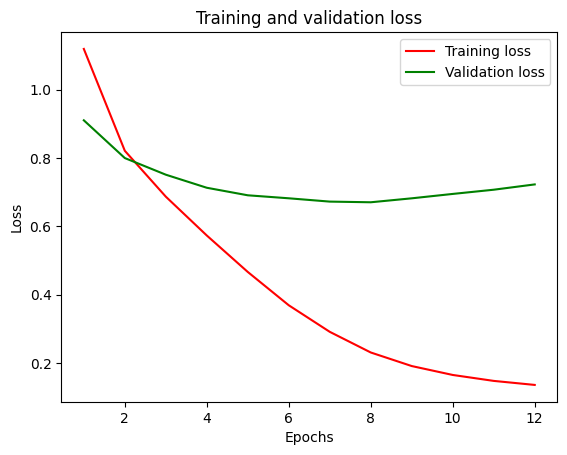

In [43]:
plt.plot(epochs1, loss1, color='red', label='Training loss')
plt.plot(epochs1, val_loss1, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

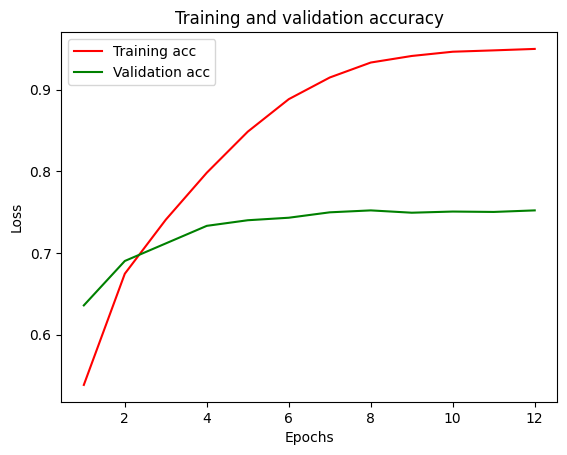

In [44]:
plt.plot(epochs1, acc1, color='red', label='Training acc')
plt.plot(epochs1, val_acc1, color='green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [45]:
y_pred = model.predict(word_seq_test)
y_pred_bool = np.argmax(y_pred, axis=1)
rounded_labels = np.argmax(y_test, axis = 1)

133/133 [==============================] - 3s 20ms/step


In [46]:
print(classification_report(rounded_labels, y_pred_bool))

              precision    recall  f1-score   support

           0       0.76      0.67      0.71      1051
           1       0.67      0.81      0.73      1099
           2       0.79      0.75      0.77      1078
           3       0.82      0.77      0.80      1001

    accuracy                           0.75      4229
   macro avg       0.76      0.75      0.75      4229
weighted avg       0.76      0.75      0.75      4229



In [47]:
print(confusion_matrix(rounded_labels, y_pred_bool))

[[702 163  86 100]
 [ 66 892  92  49]
 [ 75 167 813  23]
 [ 78 114  35 774]]


In [48]:
print(accuracy_score(rounded_labels, y_pred_bool))

0.7521872783163869
